In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.regression import LinearRegression

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 07:00:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# data processing from section 03
from pyspark.sql.types import (StructField,StringType,IntegerType,FloatType,StructType)
data_schema = [StructField('Entity',StringType(),True),
              StructField('Code',StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized',FloatType(),True)]
final_struct = StructType(fields=data_schema)
death_df = spark.read.csv("unsafewaterdeathrate.csv",schema=final_struct,header=True)

data_schema = [StructField('Entity',StringType(),True),
              StructField('Code',StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('GDP per capita, PPP (constant 2017 international $)',FloatType(),True)]
final_struct = StructType(fields=data_schema)
gdp_df = spark.read.csv("gdp-per-capita-worldbank.csv",schema=final_struct,header=True)

data_schema = [StructField('Type',StringType(),True),
              StructField('Region',StringType(),True),
              StructField("Residence Type",StringType(),True),
              StructField("Service Type",StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('Coverage',FloatType(),True),
              StructField('Population',FloatType(),True),
              StructField('Facility type',StringType(),True)]
final_struct = StructType(fields=data_schema)
wash_df = spark.read.csv("WASH.csv",schema=final_struct,header=True)

wash_df = wash_df.drop('Type')
death_df = death_df.drop('Code')

from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, FloatType, DoubleType

numeric_cols = [f.name for f in wash_df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType))]

# Identify numeric columns
numeric_cols = [f.name for f in wash_df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType))]

for column in numeric_cols:
    Q1, Q3 = wash_df.approxQuantile(column, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Coerce outliers using withColumn and when
    wash_df = wash_df.withColumn(column, 
                                 when(col(column) > upper_bound, upper_bound)
                                 .when(col(column) < lower_bound, lower_bound)
                                 .otherwise(col(column)))
    
Q1, Q3 = death_df.approxQuantile('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', [0.25, 0.75], 0.05)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with closest point
death_df = death_df.withColumn ('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', 
                               when(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized') < lower_bound, lower_bound)
                               .when(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized') > upper_bound, upper_bound)
                               .otherwise(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized')))

# filter irrelevant years
wash_df = wash_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))
death_df = death_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))
death_df = death_df.withColumnRenamed('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', 'MortalityRate')
gdp_df = gdp_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))

# compute the mean gdp by country
from pyspark.sql.functions import avg
mean_gdp_by_country = gdp_df.groupBy('Entity').agg(avg('GDP per capita, PPP (constant 2017 international $)')\
                                                   .alias('Mean GDP'))
# convert into incomelevels
income_category = mean_gdp_by_country.withColumn("IncomeLevel",
    when(col("`Mean GDP`") <= 1897.289, "Low income")
    .when((col("`Mean GDP`") > 1897.289) & (col("`Mean GDP`") <= 6464.184), "Lower middle income")
    .when((col("`Mean GDP`") > 6464.184) & (col("`Mean GDP`") <= 15324.779), "Upper middle income")
    .otherwise("High income")
)

death_gdp_df = death_df.join(income_category, death_df["Entity"] \
                             == income_category["Entity"], how='inner').drop(income_category["Entity"])

wash_df = wash_df.withColumnRenamed("Region", "IncomeLevel")

final_df = wash_df.join(death_gdp_df, on=['Year', 'IncomeLevel'], how='inner')

from pyspark.sql.types import IntegerType, DoubleType

final_df = (final_df.withColumn("Year", final_df["Year"].cast(IntegerType()))
                   .withColumn("Coverage", final_df["Coverage"].cast(DoubleType()))
                   .withColumn("MortalityRate", final_df["MortalityRate"].cast(DoubleType()))
                   .withColumn("Population", final_df["Population"].cast(DoubleType()))
                   .withColumn("Mean GDP", final_df["Mean GDP"].cast(DoubleType())))

from pyspark.sql.functions import col, when

final_df = final_df.withColumn("IncomeLevel", 
                               when(col("IncomeLevel") == "Lower middle income", 1)
                               .when(col("IncomeLevel") == "Upper middle income", 2)
                               .when(col("IncomeLevel") == "High income", 3)
                               .when(col("IncomeLevel") == "Low income", 0)
                               .otherwise(col("IncomeLevel")))

final_df = final_df.withColumn("Service Type", 
                               when(col("Service Type") == "Sanitation", 1)
                               .when(col("Service Type") == "Drinking water", 2)
                               .otherwise(col("Service Type")))

final_df = final_df.withColumn("Residence Type", 
                               when(col("Residence Type") == "total", 1)
                               .when(col("Residence Type") == "rural", 2)
                               .when(col("Residence Type") == "urban", 3)
                               .otherwise(col("Residence Type")))

final_df = final_df.withColumn("Facility type", 
                               when(col("Facility type") == "Improved latrine and other", 1)
                               .when(col("Facility type") == "Septic tank", 2)
                               .when(col("Facility type") == "Sewer", 3)
                               .when(col("Facility type") == "Non-piped improved", 4)
                               .when(col("Facility type") == "Piped improved", 5)
                               .otherwise(col("Facility type")))

final_df = (final_df.withColumn("IncomeLevel", final_df["IncomeLevel"].cast(IntegerType()))
                   .withColumn("Residence Type", final_df["Residence Type"].cast(IntegerType()))
                   .withColumn("Service Type", final_df["Service Type"].cast(IntegerType()))
                   .withColumn("Facility type", final_df["Facility type"].cast(IntegerType()))
           )

### Use Linear Regression to explore the important features

In [3]:
final_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- IncomeLevel: integer (nullable = true)
 |-- Residence Type: integer (nullable = true)
 |-- Service Type: integer (nullable = true)
 |-- Coverage: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Facility type: integer (nullable = true)
 |-- Entity: string (nullable = true)
 |-- MortalityRate: double (nullable = true)
 |-- Mean GDP: double (nullable = true)



In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
feature_cols = ['Year', 'IncomeLevel', 'Residence Type', 'Service Type', 'Coverage', 'Population', 'Facility type', 'Mean GDP']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_df = assembler.transform(final_df)
final_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- IncomeLevel: integer (nullable = true)
 |-- Residence Type: integer (nullable = true)
 |-- Service Type: integer (nullable = true)
 |-- Coverage: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Facility type: integer (nullable = true)
 |-- Entity: string (nullable = true)
 |-- MortalityRate: double (nullable = true)
 |-- Mean GDP: double (nullable = true)
 |-- features: vector (nullable = true)



In [5]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol="MortalityRate",regParam=0.01)
lr_model = lr.fit(final_df)

23/10/08 07:01:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/08 07:01:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/10/08 07:01:07 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [6]:
lr_summary = lr_model.summary
p_values = lr_summary.pValues
p_values

[1.176836406102666e-14,
 0.0,
 0.0,
 0.5127464608379315,
 0.0,
 0.0,
 0.8199779262115485,
 0.0002241553845530042,
 0.0]

In [7]:
lr2 = LinearRegression(featuresCol="features", labelCol="Coverage", regParam=0.01) 
lr_model2 = lr2.fit(final_df)

In [8]:
lr_summary2 = lr_model2.summary
p_values2 = lr_summary2.pValues
p_values2

[0.15288805753499402, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18734709030673424]

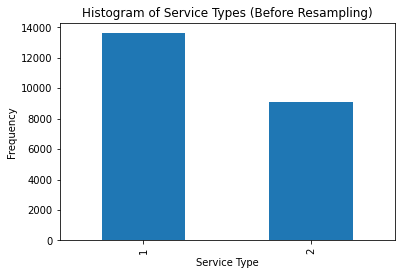

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
final_pd = final_df.toPandas()
final_pd['Service Type'].value_counts().plot(kind='bar')
plt.title('Histogram of Service Types (Before Resampling)')
plt.xlabel('Service Type')
plt.ylabel('Frequency')
plt.show()


In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ResamplingExample").getOrCreate()
df_high = final_df.filter(final_df["Service Type"] == 1)
df_low = final_df.filter(final_df["Service Type"] == 2)
num_samples_low = df_low.count()

df_high_resampled = df_high.sample(fraction=num_samples_low / df_high.count(), seed=123)

df_resampled = df_high_resampled.union(df_low)

df_resampled.show()


+----+-----------+--------------+------------+------------------+------------+-------------+------+-----------------+------------------+--------------------+
|Year|IncomeLevel|Residence Type|Service Type|          Coverage|  Population|Facility type|Entity|    MortalityRate|          Mean GDP|            features|
+----+-----------+--------------+------------+------------------+------------+-------------+------+-----------------+------------------+--------------------+
|2019|          0|             3|           1| 16.16663932800293| 3.4751936E7|            3|  Chad|7.417001601308584|1709.7349700927734|[2019.0,0.0,3.0,1...|
|2019|          0|             2|           1|2.2255399227142334|   9654262.0|            3|  Chad|7.417001601308584|1709.7349700927734|[2019.0,0.0,2.0,1...|
|2019|          0|             3|           1|14.180439949035645| 3.0482388E7|            2|  Chad|7.417001601308584|1709.7349700927734|[2019.0,0.0,3.0,1...|
|2019|          0|             2|           1| 2.728

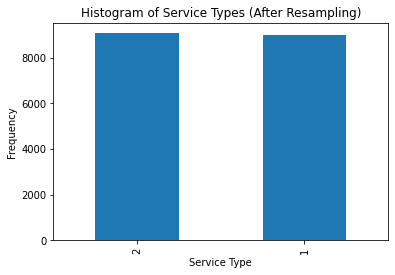

In [11]:
pd_resampled = df_resampled.toPandas()

pd_resampled['Service Type'].value_counts().plot(kind='bar')
plt.title('Histogram of Service Types (After Resampling)')
plt.xlabel('Service Type')
plt.ylabel('Frequency')
plt.show()

In [13]:
from pyspark.ml.regression import LinearRegression
lr3 = LinearRegression(featuresCol="features", labelCol="MortalityRate",regParam=0.01)
lr_model3 = lr3.fit(final_df)

In [14]:
lr_summary3 = lr_model3.summary
p_values3 = lr_summary3.pValues
p_values3

[1.176836406102666e-14,
 0.0,
 0.0,
 0.5127464608379315,
 0.0,
 0.0,
 0.8199779262115485,
 0.0002241553845530042,
 0.0]

## Data Projection

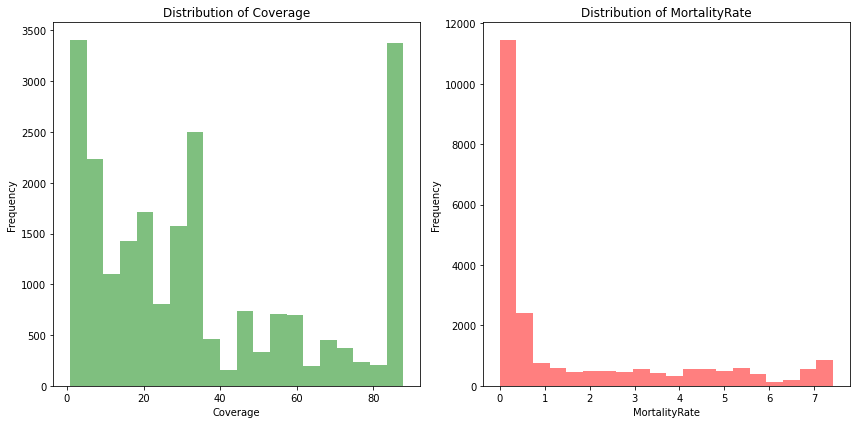

In [15]:
final_df_pd = final_df.select('Coverage', 'MortalityRate').toPandas()

plt.figure(figsize=(12, 6))

# Plot the distribution of 'Coverage'
plt.subplot(1, 2, 1)
plt.hist(final_df_pd['Coverage'], bins=20, alpha=0.5, color='g', label='Coverage')
plt.title('Distribution of Coverage')
plt.xlabel('Coverage')
plt.ylabel('Frequency')

# Plot the distribution of 'MortalityRate'
plt.subplot(1, 2, 2)
plt.hist(final_df_pd['MortalityRate'], bins=20, alpha=0.5, color='r', label='MortalityRate')
plt.title('Distribution of MortalityRate')
plt.xlabel('MortalityRate')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

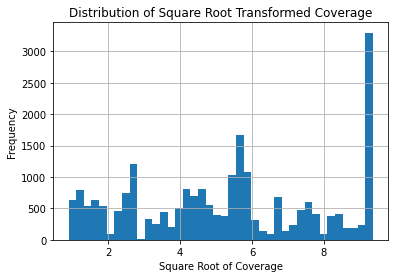

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import sqrt
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("DataTransformation").getOrCreate()

final_df_transformed = final_df.withColumn("sqrt_Coverage", sqrt(final_df["Coverage"]))
final_df_transformed_pd = final_df_transformed.select("sqrt_Coverage").toPandas()

plt.hist(final_df_transformed_pd["sqrt_Coverage"], bins=40)
plt.title("Distribution of Square Root Transformed Coverage")
plt.xlabel("Square Root of Coverage")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

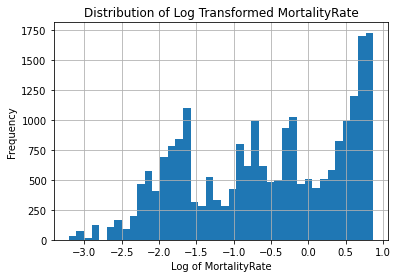

In [20]:
from pyspark.sql.functions import log10

final_df_transformed = final_df.withColumn("log_MortalityRate", log10(final_df["MortalityRate"]))

final_df_transformed_pd = final_df_transformed.select("log_MortalityRate").toPandas()

# Plot the distribution of the log-transformed 'MortalityRate'
plt.hist(final_df_transformed_pd["log_MortalityRate"], bins=40)
plt.title("Distribution of Log Transformed MortalityRate")
plt.xlabel("Log of MortalityRate")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()